# Part 3: Random Forest

###

In [259]:
import sys
!{sys.executable} -m pip install pandas_profiling
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install scikit-learn-intelex
!{sys.executable} -m spacy download en_core_web_md


  Using cached daal-2021.4.0-py2.py3-none-win_amd64.whl (69.0 MB)
  Using cached tbb-2021.7.1-py3-none-win_amd64.whl (278 kB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


     ---------------------------------------- 42.8/42.8 MB 4.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
import nltk
import re
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearnex import patch_sklearn, config_context
from sklearn.pipeline import make_pipeline
patch_sklearn() # SW AI Accelerator for Intel CPUs. EXCLUDE IF NOT USING INTEL CPU.

adasyn=ADASYN()
sb.set()

""" NOTE: SET YOUR PROJECT ROOT DIRECTORY HERE """
PROJ_DIR = r""
RANDOM_SPLIT_SEED = 11

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [261]:
data=pd.read_csv('fake_job_postings.csv')
data

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [262]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

y = pd.DataFrame(data['fraudulent'])
X = pd.DataFrame(data[['telecommuting', 'has_company_logo', 'has_questions']])


In [263]:
def rate(confusion_matrix):
    TrueNe=confusion_matrix[0][0]/((confusion_matrix[0][0])+(confusion_matrix[0][1]))
    print("True Negative rate is: ", TrueNe)
    TruePos=confusion_matrix[1][1]/((confusion_matrix[1][1])+(confusion_matrix[1][0]))
    print("True Positive rate is: ", TruePos)
    FasNe=confusion_matrix[1][0]/((confusion_matrix[1][0])+(confusion_matrix[1][1]))
    print("False negative rate is: ", FasNe)
    FasPos=confusion_matrix[0][1]/((confusion_matrix[0][0])+(confusion_matrix[0][1]))
    print("False Positive rate is: ", FasPos)

For train model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0
For test model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0


[Text(0.5, 0.875, 'has_company_logo <= 0.5\ngini = 0.092\nsamples = 14304\nvalue = [13611, 693]\nclass = real'),
 Text(0.25, 0.625, 'has_questions <= 0.5\ngini = 0.267\nsamples = 2907\nvalue = [2445, 462]\nclass = real'),
 Text(0.125, 0.375, 'telecommuting <= 0.5\ngini = 0.296\nsamples = 2146\nvalue = [1759, 387]\nclass = real'),
 Text(0.0625, 0.125, 'gini = 0.29\nsamples = 2054\nvalue = [1693, 361]\nclass = real'),
 Text(0.1875, 0.125, 'gini = 0.405\nsamples = 92\nvalue = [66, 26]\nclass = real'),
 Text(0.375, 0.375, 'telecommuting <= 0.5\ngini = 0.178\nsamples = 761\nvalue = [686, 75]\nclass = real'),
 Text(0.3125, 0.125, 'gini = 0.176\nsamples = 707\nvalue = [638, 69]\nclass = real'),
 Text(0.4375, 0.125, 'gini = 0.198\nsamples = 54\nvalue = [48, 6]\nclass = real'),
 Text(0.75, 0.625, 'telecommuting <= 0.5\ngini = 0.04\nsamples = 11397\nvalue = [11166, 231]\nclass = real'),
 Text(0.625, 0.375, 'has_questions <= 0.5\ngini = 0.038\nsamples = 10935\nvalue = [10723, 212]\nclass = real')

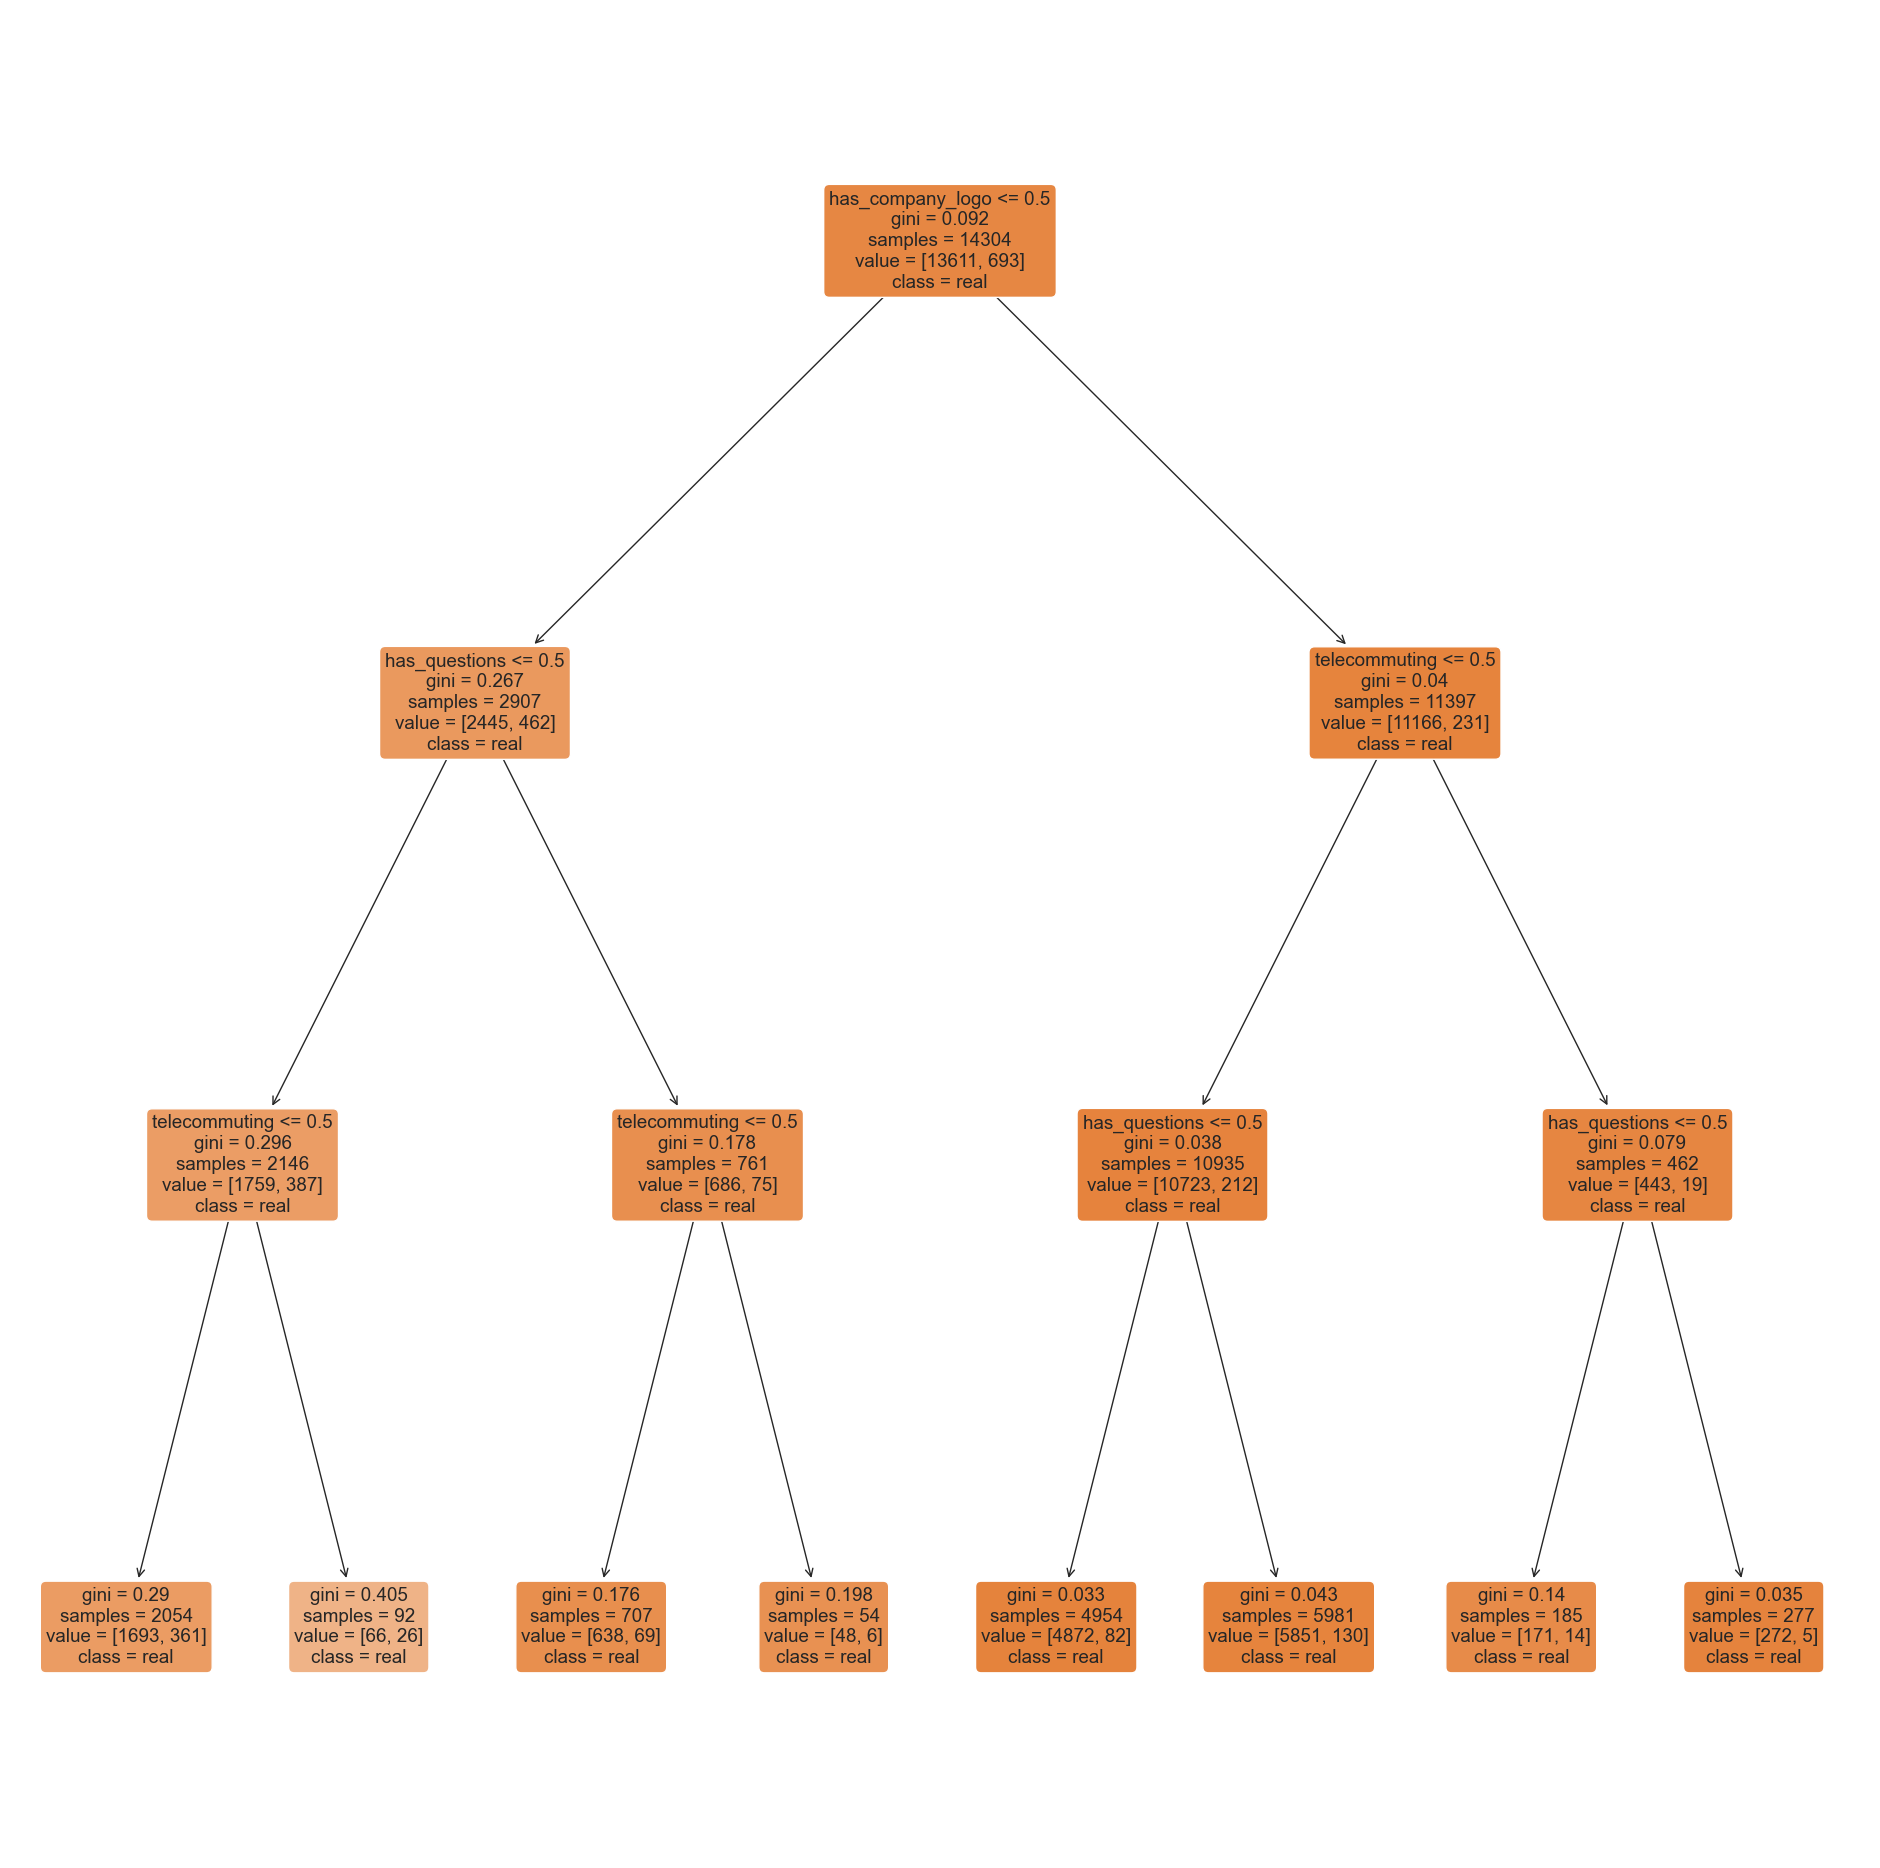

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

dectree = DecisionTreeClassifier(max_depth = 4)  
dectree.fit(X_train, y_train)       


y_train_predic=dectree.predict(X_train)
y_test_predic=dectree.predict(X_test)

print("For train model: ")
rate(confusion_matrix(y_train, y_train_predic))
print("For test model: ")
rate(confusion_matrix(y_test, y_test_predic))


f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["real","false"])

<AxesSubplot:>

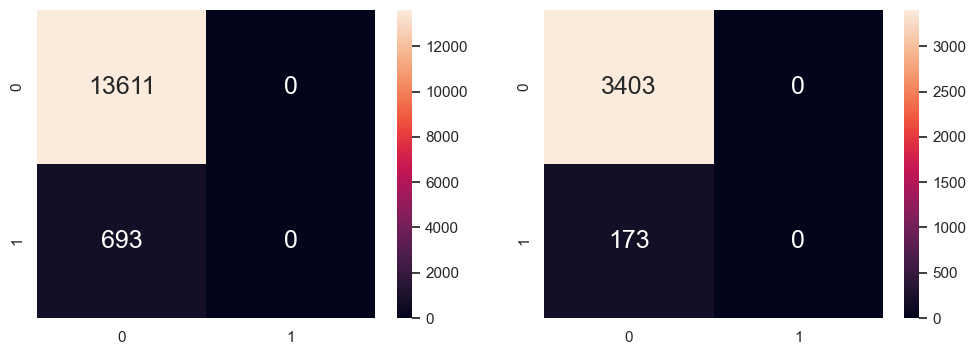

In [265]:
f, axes=plt.subplots(1, 2, figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

For train model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0
For test model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0


[Text(0.5, 0.875, 'has_company_logo <= 0.5\ngini = 0.092\nsamples = 14304\nvalue = [13611, 693]\nclass = real'),
 Text(0.25, 0.625, 'has_questions <= 0.5\ngini = 0.267\nsamples = 2907\nvalue = [2445, 462]\nclass = real'),
 Text(0.125, 0.375, 'telecommuting <= 0.5\ngini = 0.296\nsamples = 2146\nvalue = [1759, 387]\nclass = real'),
 Text(0.0625, 0.125, 'gini = 0.29\nsamples = 2054\nvalue = [1693, 361]\nclass = real'),
 Text(0.1875, 0.125, 'gini = 0.405\nsamples = 92\nvalue = [66, 26]\nclass = real'),
 Text(0.375, 0.375, 'telecommuting <= 0.5\ngini = 0.178\nsamples = 761\nvalue = [686, 75]\nclass = real'),
 Text(0.3125, 0.125, 'gini = 0.176\nsamples = 707\nvalue = [638, 69]\nclass = real'),
 Text(0.4375, 0.125, 'gini = 0.198\nsamples = 54\nvalue = [48, 6]\nclass = real'),
 Text(0.75, 0.625, 'telecommuting <= 0.5\ngini = 0.04\nsamples = 11397\nvalue = [11166, 231]\nclass = real'),
 Text(0.625, 0.375, 'has_questions <= 0.5\ngini = 0.038\nsamples = 10935\nvalue = [10723, 212]\nclass = real')

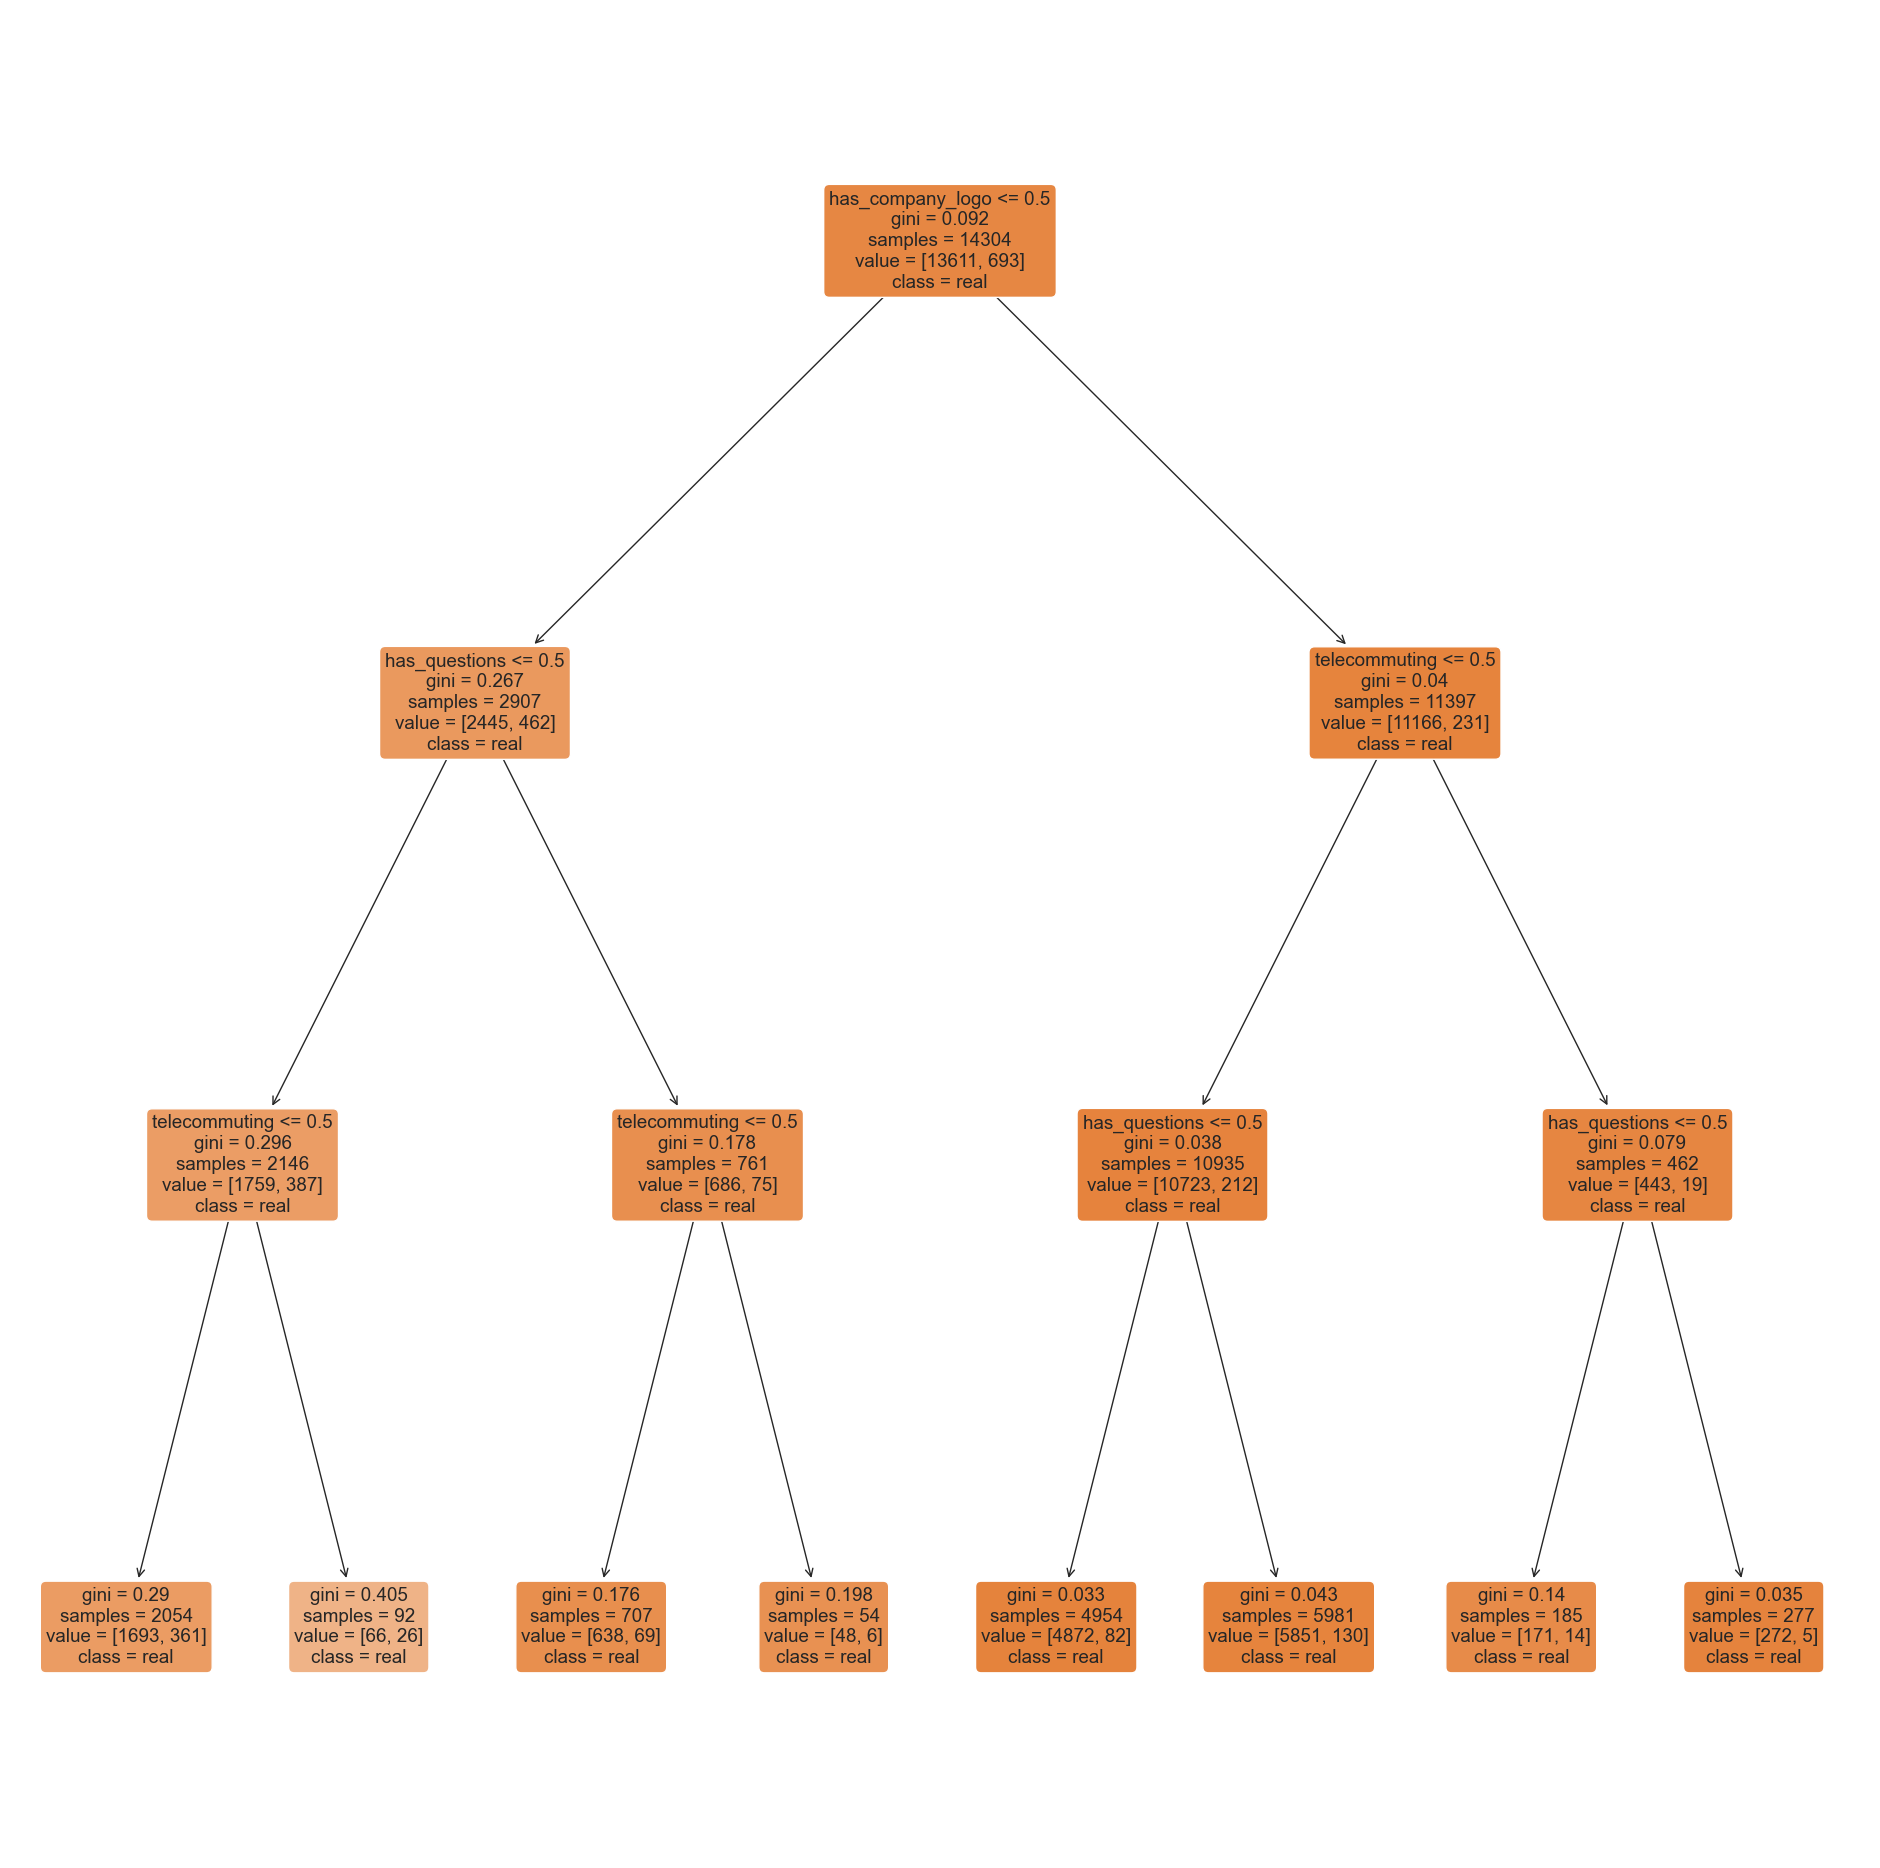

In [266]:
dectree = DecisionTreeClassifier(max_depth = 10)  
dectree.fit(X_train, y_train)


y_train_predic=dectree.predict(X_train)
y_test_predic=dectree.predict(X_test)

print("For train model: ")
rate(confusion_matrix(y_train, y_train_predic))
print("For test model: ")
rate(confusion_matrix(y_test, y_test_predic))


f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["real","false"])

<AxesSubplot:>

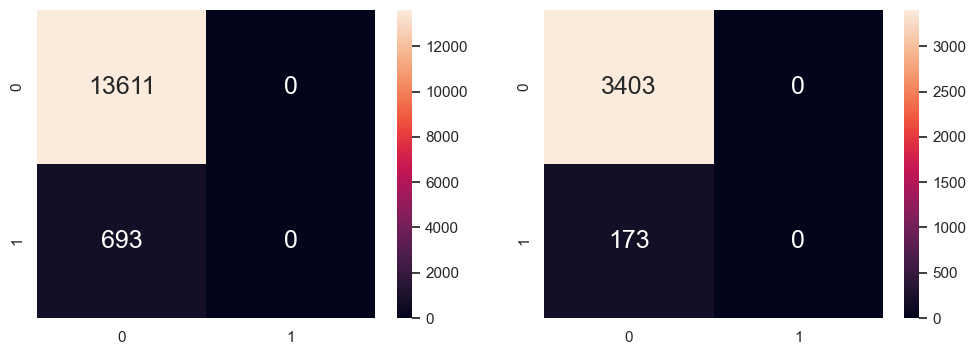

In [267]:
f, axes=plt.subplots(1, 2, figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

For train model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0
For test model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0


<AxesSubplot:>

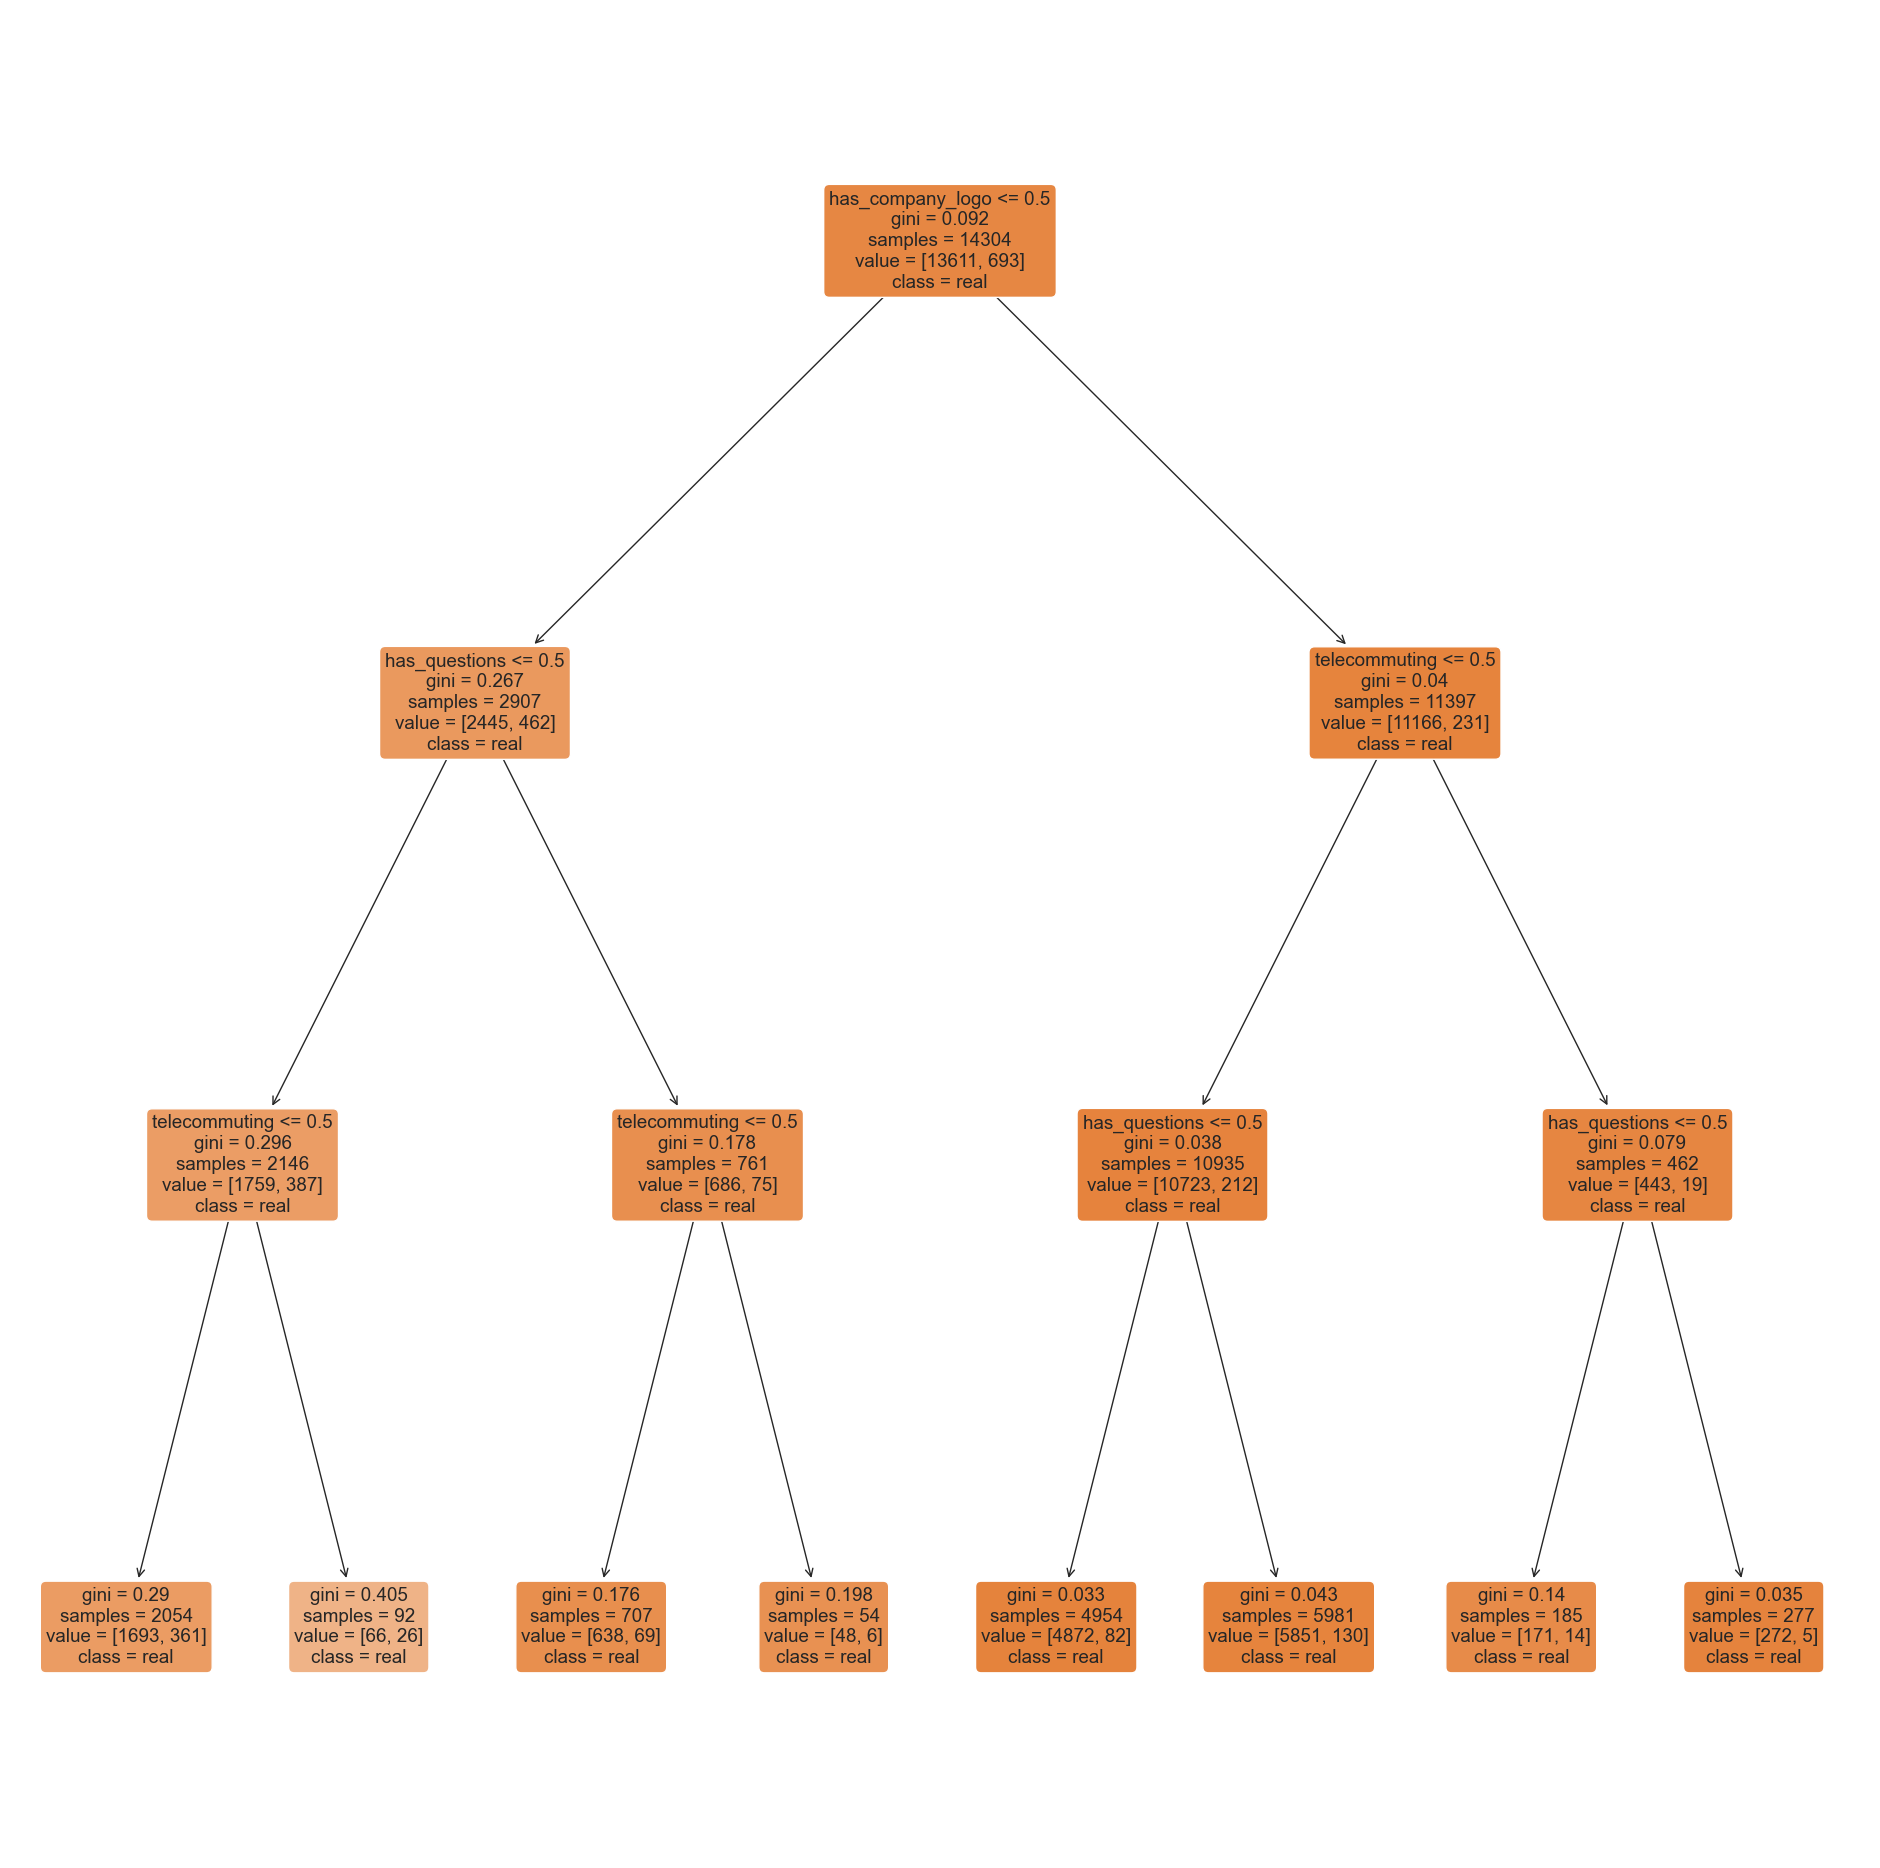

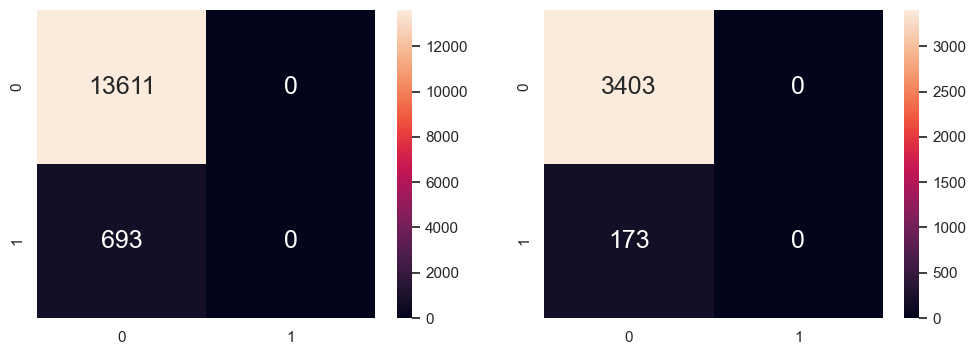

In [268]:
dectree = DecisionTreeClassifier(max_depth = 50)  
dectree.fit(X_train, y_train)       


y_train_predic=dectree.predict(X_train)
y_test_predic=dectree.predict(X_test)

print("For train model: ")
rate(confusion_matrix(y_train, y_train_predic))
print("For test model: ")
rate(confusion_matrix(y_test, y_test_predic))


f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["real","false"])

f, axes=plt.subplots(1, 2, figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

As seen, the model used by decision trees has 1 true negative rate and 0 false positive rate, but it has very high false negative rate of 1 and very low true positive rate of 0. Which means that decision tree  might not be a good model to classify the fraudulent of this question. Next, the model of random forest was used to help classify the fraudulent of this question. 

In [269]:
from sklearn.ensemble import RandomForestClassifier

# Now, the Random Forest object is created:
ran_frt = RandomForestClassifier(n_estimators = 100,  
                                 max_depth = 4)  

# Random Forest is fitted on Train and Test Data:
ran_frt.fit(X_train, y_train)

C:\Users\tian\anaconda3\lib\site-packages\daal4py\sklearn\ensemble\_forest.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return _fit_classifier(self, X, y, sample_weight=sample_weight)


RandomForestClassifier(max_depth=4)

In [270]:
y_train_predt=ran_frt.predict(X_train)
y_test_predt=ran_frt.predict(X_test)
print("The accuracy of train data set is: ", ran_frt.score(X_train, y_train))
print("The accuracy of test data set is: ", ran_frt.score(X_test, y_test))


print("For train model: ")
rate(confusion_matrix(y_train, y_train_predt))
print("For test model: ")
rate(confusion_matrix(y_test, y_test_predt))

The accuracy of train data set is:  0.9515520134228188
The accuracy of test data set is:  0.9516219239373602
For train model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0
For test model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0


<AxesSubplot:>

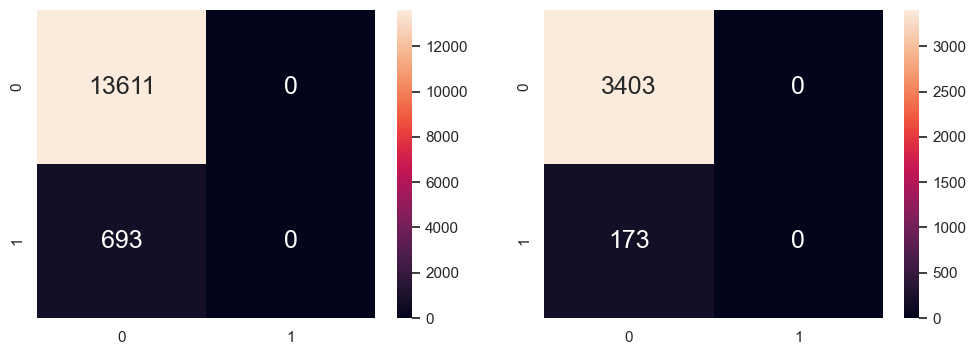

In [271]:
f, axes=plt.subplots(1, 2, figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_predt), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_predt), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

As seen, using the model of random forest still does not really help reducing false negative rate and increasing true positive rate. Next, more trees are added to the random forest to see if it can help to build a better model with reducing false negative rate and increasing true positive rate. 

In [272]:
ran_frt = RandomForestClassifier(n_estimators = 2000,  
                                 max_depth = 4)  

# Random Forest is fitted on Train and Test Data:
ran_frt.fit(X_train, y_train)

C:\Users\tian\anaconda3\lib\site-packages\daal4py\sklearn\ensemble\_forest.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return _fit_classifier(self, X, y, sample_weight=sample_weight)


RandomForestClassifier(max_depth=4, n_estimators=2000)

In [273]:
y_train_predt=ran_frt.predict(X_train)
y_test_predt=ran_frt.predict(X_test)
print("The accuracy of train data set is: ", ran_frt.score(X_train, y_train))
print("The accuracy of test data set is: ", ran_frt.score(X_test, y_test))

print("For train model: ")
rate(confusion_matrix(y_train, y_train_predt))

print("For test model: ")
rate(confusion_matrix(y_test, y_test_predt))

The accuracy of train data set is:  0.9515520134228188
The accuracy of test data set is:  0.9516219239373602
For train model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0
For test model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0


<AxesSubplot:>

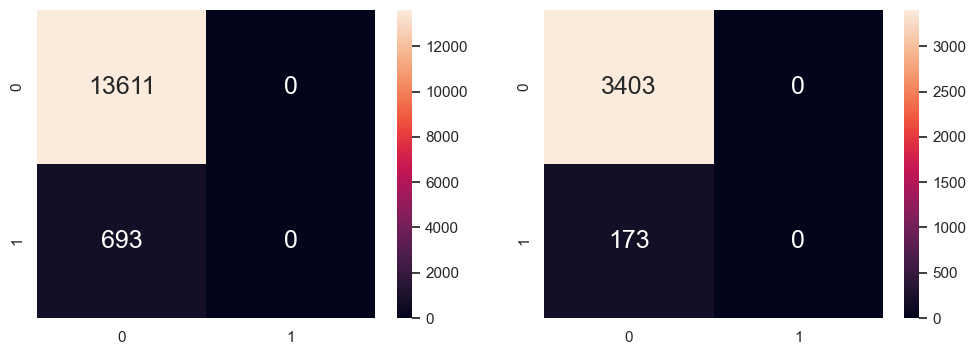

In [274]:
f, axes=plt.subplots(1, 2, figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_predt), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_predt), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

Unfortunately, increasing the number of trees in the random forest still does not help reducing false negative rate and increasing true positive rate. Next,more trees are added to see if it can help to build a better model with reducing false negative rate and increasing true positive rate.

Next, while maintaining the number of trees in the random forest to be unchanged, test if increasing the depth of the trees in the random forest can help reducing false negative rate and increasing true positive rate. 

In [275]:
ran_frt = RandomForestClassifier(n_estimators = 2000,  
                                 max_depth = 50)  

# Random Forest is fitted on Train and Test Data:
ran_frt.fit(X_train, y_train)

C:\Users\tian\anaconda3\lib\site-packages\daal4py\sklearn\ensemble\_forest.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return _fit_classifier(self, X, y, sample_weight=sample_weight)


RandomForestClassifier(max_depth=50, n_estimators=2000)

In [276]:
y_test_predt=ran_frt.predict(X_test)
print("The accuracy of test data set is: ", ran_frt.score(X_train, y_train))

print("For train model: ")
rate(confusion_matrix(y_train, y_train_predt))

print("For test model: ")
rate(confusion_matrix(y_test, y_test_predt))

The accuracy of test data set is:  0.9515520134228188
For train model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0
For test model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0


<AxesSubplot:>

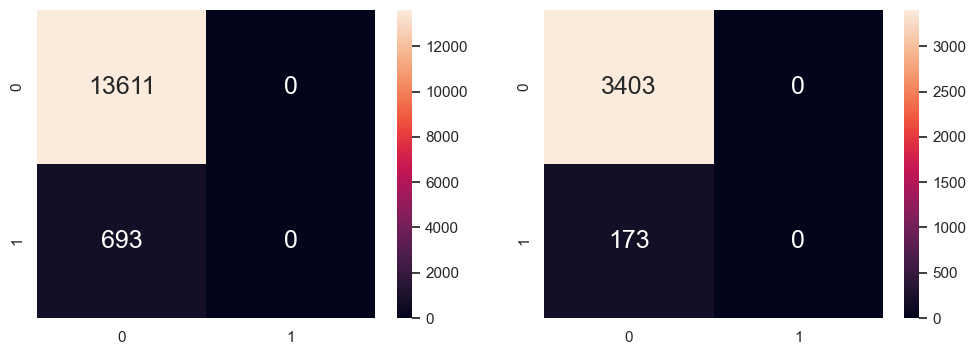

In [277]:
f, axes=plt.subplots(1, 2, figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_predt), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_predt), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

Again, increasing the depth of the trees in the forest does not help increasing the depth of the trees in the random forest can help reducing false negative rate or increasing true positive rate neither. 

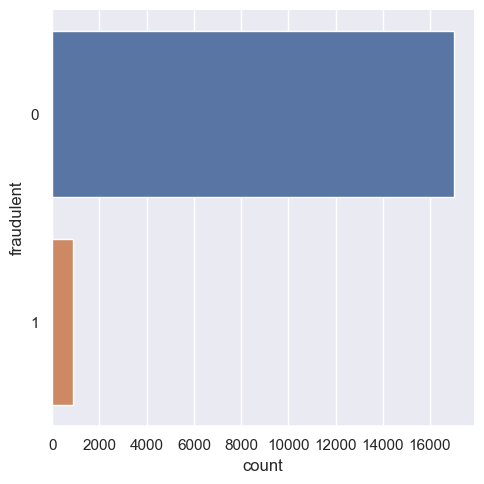

In [278]:
sb.catplot(y = 'fraudulent', data = data, kind = "count")

In [279]:
T_proportion, F_proportion = data['fraudulent'].value_counts()
print("Ratio of job that is real:fake = ", T_proportion, ":", F_proportion)

Ratio of job that is real:fake =  17014 : 866


As seen, there is a highly umbalance proportion of real job and fake job in the dataset that is given.

Therefore, this question is not a normal classification type of problems, because it has highly imbalance fraudulent of jobs. As a consequence, this question cannot be solved simply by just using the approaches of drawing decision trees or random forest. There may need other models involving language processing and anaysis, such as Recurrent Neural Network(RNN) and Support Vector Classifier(SVC). 